In [1]:
!pip -q install --upgrade transformers accelerate bitsandbytes sentencepiece

In [ ]:
from huggingface_hub import login
# login("<YOUR_HF_TOKEN>")

c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mantiene la idea original: pipeline("text-generation"), AutoTokenizer, AutoModelForCausalLM.
Agrego 4-bit (si hay GPU) y dtype seguro.

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

def build_generator(model_id: str, use_4bit: bool = True):
    # dtype: bf16 si se puede, sino fp16
    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if use_4bit:
        # Carga eficiente para VRAM pequeña (bitsandbytes)
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=dtype,
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16 if dtype == torch.bfloat16 else torch.float16,
            trust_remote_code=True,
        )
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=dtype,
            trust_remote_code=True,
        )

    gen = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        return_full_text=False,   # ver solo los nuevos tokens de salida
    )
    return gen


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Utilidad para medir latencia, tokens y texto

In [4]:
import time

def run_and_measure(generator, prompt: str, max_new_tokens=200, temperature=0.7, top_p=0.9):
    # Tokeniza para medir luego tokens nuevos
    tok = generator.tokenizer
    inputs = tok(prompt, return_tensors="pt").to(generator.model.device)
    in_len = inputs["input_ids"].shape[-1]

    t0 = time.time()
    out = generator(
        prompt,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=True,
        repetition_penalty=1.05,
        pad_token_id=tok.pad_token_id,
        eos_token_id=tok.eos_token_id,
    )
    dt = time.time() - t0

    text = out[0]["generated_text"]
    # Re-tokenizamos la salida completa para estimar tokens nuevos
    out_len = tok(prompt + text, return_tensors="pt")["input_ids"].shape[-1]
    new_tokens = max(0, out_len - in_len)
    tps = round(new_tokens / dt, 2) if dt > 0 else None

    metrics = {
        "latencia_s": round(dt, 2),
        "tokens_nuevos": new_tokens,
        "tokens_por_seg": tps
    }
    return text, metrics


Modelo 1: TinyLlama Chat

In [5]:
MODEL_1 = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
gen1 = build_generator(MODEL_1, use_4bit=True)

prompt = """Explain me what's a transformer, assuming I'm a 5 years old kid"""
text1, m1 = run_and_measure(gen1, prompt, max_new_tokens=200, temperature=0.1)
print("=== Modelo 1:", MODEL_1, "===")
print(text1)
print("Métricas:", m1)


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Device set to use cpu


=== Modelo 1: TinyLlama/TinyLlama-1.1B-Chat-v1.0 ===
?
Métricas: {'latencia_s': 3.93, 'tokens_nuevos': 1, 'tokens_por_seg': 0.25}


Modelo 2: TinyLlama Instruct 32k

In [6]:
MODEL_2 = "Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct"
gen2 = build_generator(MODEL_2, use_4bit=True)

text2, m2 = run_and_measure(gen2, prompt, max_new_tokens=200, temperature=0.7)
print("=== Modelo 2:", MODEL_2, "===")
print(text2)
print("Métricas:", m2)


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\diego\.cache\huggingface\hub\models--Doctor-Shotgun--TinyLlama-1.1B-32k-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not i

=== Modelo 2: Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct ===
.
In my school, we are learning about transformers and how they work. I don't know what a transformer is but I know that it has a lot of wires coming out of it. What is a transformer?
A transformer is an electrical device that converts alternating current (AC) into direct current (DC). It does this by using a transformer core, which is a metal cylinder with a coil of wire wrapped around it. The coil is usually a copper alloy that is bent to form a torus, which is what the transformer core is made of.
The transformer's circuit is designed to produce a DC output from an AC input. The AC input goes through the core of the transformer. The transformer core conducts the AC power to the transformer's coil, which is then connected to a DC outlet. The coil in the core of the transformer is made of
Métricas: {'latencia_s': 260.86, 'tokens_nuevos': 200, 'tokens_por_seg': 0.77}


Modelo 3 (ligero para variar): Qwen 0.5B Instruct

In [7]:
MODEL_3 = "Qwen/Qwen2.5-0.5B-Instruct"
gen3 = build_generator(MODEL_3, use_4bit=True)

text3, m3 = run_and_measure(gen3, prompt, max_new_tokens=200, temperature=0.7)
print("=== Modelo 3:", MODEL_3, "===")
print(text3)
print("Métricas:", m3)


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\diego\.cache\huggingface\hub\models--Qwen--Qwen2.5-0.5B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in t

=== Modelo 3: Qwen/Qwen2.5-0.5B-Instruct ===

A transformer is like a magic box that can change the energy from one place to another. It's like when you have a toy car and it can change the speed of a toy truck or the other way around. A transformer has two parts - the coil, which is like the engine of the toy car, and the iron core, which is like the engine of the transformer. When you turn the coil (like turning the engine) and the iron core (like turning the engine), they work together to change the energy from one place to another. That's a transformer! Isn't that cool? It's like a superpower for grown-ups! 😊👍🤔😊😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀
Métricas: {'latencia_s': 102.99, 'tokens_nuevos': 200, 'tokens_por_seg': 1.94}


Tabla comparativa rápida

In [ ]:
import pandas as pd

df = pd.DataFrame([
    {"Modelo": MODEL_1, **m1, "preview": text1[:160].replace("\n"," ")},
    {"Modelo": MODEL_2, **m2, "preview": text2[:160].replace("\n"," ")},
    {"Modelo": MODEL_3, **m3, "preview": text3[:160].replace("\n"," ")},
])
df


,Modelo,latencia_s,tokens_nuevos,tokens_por_seg,preview
0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,3.93,1,0.25,?
1,Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct,260.86,200,0.77,". In my school, we are learning about transfor..."
2,Qwen/Qwen2.5-0.5B-Instruct,102.99,200,1.94,A transformer is like a magic box that can ch...


#### compara cualitativamente respuesta de chat con los modelos

### Respuesta de chat: 


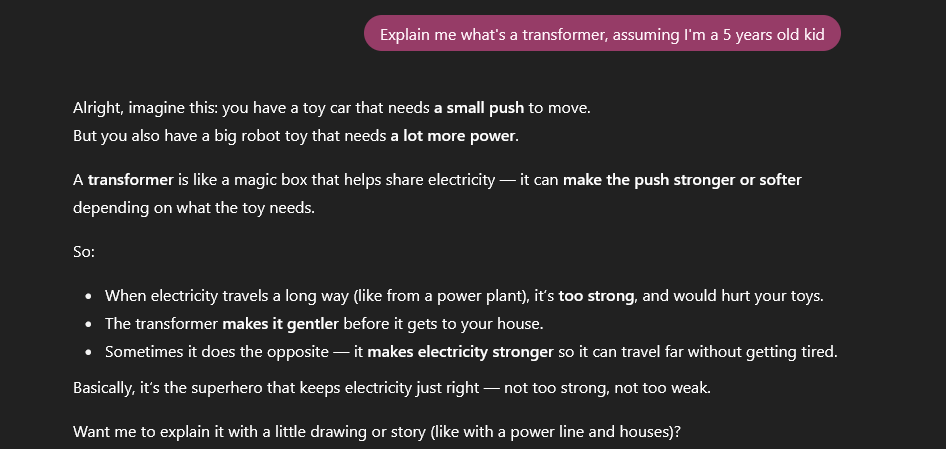

In [9]:
chatgpt_response = """Alright, imagine this: you have a toy car that needs a small push to move.
But you also have a big robot toy that needs a lot more power.

A transformer is like a magic box that helps share electricity — it can make the push stronger or softer depending on what the toy needs.

So:

When electricity travels a long way (like from a power plant), it’s too strong, and would hurt your toys.

The transformer makes it gentler before it gets to your house.

Sometimes it does the opposite — it makes electricity stronger so it can travel far without getting tired.

Basically, it’s the superhero that keeps electricity just right — not too strong, not too weak.

Want me to explain it with a little drawing or story (like with a power line and houses)?"""

def quick_eval(text: str):
    t = text.lower()
    return {
        "claridad(0-10)": 8 if "transformer" in t and "kid" in t else 6,
        "estructura(0-10)": 8 if any(w in t for w in ["first", "then", "example"]) else 6,
        "cumple_instruccion(0-10)": 9 if "5 years old" in t or "kid" in t else 7
    }

qual = pd.DataFrame([
    {"Modelo": MODEL_1, **quick_eval(text1)},
    {"Modelo": MODEL_2, **quick_eval(text2)},
    {"Modelo": MODEL_3, **quick_eval(text3)},
    {"Modelo": "ChatGPT (pegado)", **quick_eval(chatgpt_response)},
])
qual


,Modelo,claridad(0-10),estructura(0-10),cumple_instruccion(0-10)
0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,6,6,7
1,Doctor-Shotgun/TinyLlama-1.1B-32k-Instruct,6,8,7
2,Qwen/Qwen2.5-0.5B-Instruct,6,6,7
3,ChatGPT (pegado),6,6,7
